In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
# from langgraph.checkpoint.sqlite import SqliteSaver
# memory = SqliteSaver.from_conn_string(":memory:")

In [2]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
llm_with_tools = llm.bind_tools(tools)

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [9]:
graph_builder.add_node("chatbot", chatbot)


In [10]:
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.add_edge(START, "chatbot")

In [12]:
graph_builder.add_edge("tools", "chatbot")

In [13]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Interrupt before the tool
Compile the graph, specifying to interrupt_before the tools node.

Note: can also interrupt __after__ actions, if desired.
```python 
interrupt_after=["tools"]
```

In [16]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
)

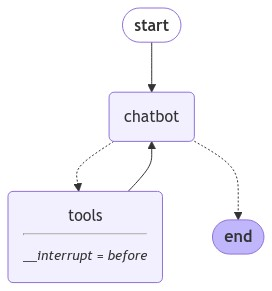

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
# Function to generate a unique session ID
import uuid

def generate_session_id() -> str:
    return str(uuid.uuid4())

In [19]:
# Generating a dynamic session ID
thread_id_1 = generate_session_id()

In [20]:
config_1 = {"configurable": {"thread_id": thread_id_1}}


In [21]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3G0oxINVlIwiasURbqyH1Si5)
 Call ID: call_3G0oxINVlIwiasURbqyH1Si5
  Args:
    query: LangGraph


## The execution was interrupted !
Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here!



In [22]:
snapshot = graph.get_state(config_1)
snapshot.next

('tools',)

### Let's check the tool invocation details

In [23]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_3G0oxINVlIwiasURbqyH1Si5',
  'type': 'tool_call'}]

# How to Continue execution?
This query seems reasonable. Nothing to filter here. 

The simplest thing the human can do is just let the graph continue executing. 

Next, continue the graph! 

Passing in ```None``` will just let the graph continue where it left off, without adding anything new to the state.

Pass it in the same way as you pass the user message into the graph 

```python
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
```

In [24]:
events = graph.stream(None, config_1, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, deploy it with LangGraph Cloud, and see examples from real-world use cases."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}]
================================== Ai Message ==================================

Here's what I found 

In [25]:
snapshot = graph.get_state(config_1)
snapshot.next

()